In [5]:
import numpy as np 
from numpy import sin, cos
from math import atan2
from pydrake.all import LeafSystem, BasicVector
from pydrake.systems.framework import Context, ContinuousState



In [247]:


class PlanarPRR(LeafSystem):

    def __init__(self):

        LeafSystem.__init__(self)

        self.M = np.zeros((3, 3))
        self.C = np.zeros((3))
        self.ActuationMatrix = np.zeros((3, 2))
        self.Jac = np.zeros((3, 3))

        # def joint limit: 
        self.limit_q1 = 12
        self.limit_q2 = np.pi
        self.limit_q3 = np.pi

        group_index = self.DeclareContinuousState(6)

        self.DeclareVectorInputPort("F", BasicVector(2))
        self.DeclareStateOutputPort("state", group_index)
        
        self.init_dynamic_model_parameters()

    def DoCalcTimeDerivatives(self, context:Context, derivatives_out:ContinuousState):

        fx, fy = self.get_input_port(0).Eval(context)
        F = np.array([fx, fy])
        state = context.get_continuous_state_vector()

        # test on fixing joint limit. Still to do: this next lines doesn't work
        #dq1 = min(max(state[3], -self.limit_q1), self.limit_q1)
        #dq2 = min(max(state[4], -self.limit_q2), self.limit_q2)
        #dq3 = min(max(state[5], -self.limit_q3), self.limit_q3)

        dq1, dq2, dq3 = state[3], state[4], state[5]
        self.eval_dyn_model(state_vect=state)
        q_dot = np.array([dq1, dq2, dq3])
        q_dot_dot = np.linalg.inv(self.M) @ ((self.ActuationMatrix @ F) - self.C)
        derivatives = np.concatenate( (q_dot, q_dot_dot) )
        derivatives_out.get_mutable_vector().SetFromVector(derivatives)

    def init_dynamic_model_parameters(self):

        self.m = [1, 1, 1]
        self.I = [1, 1, 1]
        self.d = [None, 0.5, 0.5]
        self.l = [None, 1, 1]  # the first is none because is q1
        
        self.a1 = self.m[0] + self.m[1] + self.m[2]
        self.a2 = self.I[1] + self.m[1] * (self.d[1]**2) + self.m[2]*(self.l[2]**2)
        self.a3 = self.I[2] + self.m[2] * (self.d[2]**2)
        self.a4 = self.m[2] * self.d[2]
        self.a5 = self.m[1] * self.d[1] + self.m[2] * self.l[1]

    def eval_dyn_model(self, state_vect):
        self._eval_M_of_q(state_vect)
        self._eval_C_of_q(state_vect)
        self._eval_actuation_matrix(state_vect)

    def _eval_M_of_q(self, state_vect):

        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]
        
        self.M[0, 0] =  self.a1
        self.M[0, 1] = -self.a5 * sin(q2)  - self.a4 * sin(q2 + q3)
        self.M[0, 2] = -self.a4 * sin(q2 + q3)

        self.M[1, 0] = -self.a5 * sin(q2) - self.a4 * sin(q2 + q3)
        self.M[1, 1] = self.a2 + self.a3 + 2*self.a4 * self.l[1] * cos(q3)
        self.M[1, 2] = self.a3 + self.a4 * self.l[1] * cos(q3)

        self.M[2, 0] = -self.a4 * sin(q2 + q3)
        self.M[2, 1] = self.a3 + self.a4 * self.l[1] * cos(q3)
        self.M[2, 2] = self.a3

    def _eval_C_of_q(self, state_vect):
    
        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]
        dq1, dq2, dq3 = state_vect[3], state_vect[4], state_vect[5]

        self.C[0] = (-self.a5*cos(q2) + self.a4*cos(q2+q3))*(dq2**2) - self.a4*cos(q2+q3)*dq3*(dq2 + dq3)
        self.C[1] = -self.a4 * self.l[1] * sin(q3) * dq3 * (2*dq2 + dq3)
        self.C[2] = self.a4 * self.l[2] * sin(q3) * (dq2**2)

    def _eval_actuation_matrix(self, state_vect):

        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]

        self.ActuationMatrix[0, 0]  = 1
        self.ActuationMatrix[0, 1]  = 0 
        
        self.ActuationMatrix[1, 0] = -self.l[1] * sin(q2) - self.l[2] * sin(q2 + q3)
        self.ActuationMatrix[1, 1] = -self.l[1] * cos(q2) - self.l[2] * cos(q2 + q3)
        
        self.ActuationMatrix[2, 0] = -self.l[1] * sin(q2) 
        self.ActuationMatrix[2, 1] = -self.l[1] * cos(q2)


class PlanarPRR_inTheta(PlanarPRR):

    def __init__(self):

        PlanarPRR.__init__(self)
        
        self.M_of_theta = np.zeros((3, 3))
        self.C_of_theta = np.zeros((3))
        self.ActuationMatrix = np.array([[1, 0], [0, 1], [0, 0]])
        self.DeclareVectorInputPort('q_vect', BasicVector(6))
        # in theory it's possible to define the same actuation matrix of before and get the same numerical result
        # but, considering that the new actuation matrix will be constant, I prefer to fix it here 

        self.Jac_h = np.zeros((3, 3))
        self.Jac_h_dot = np.zeros((3, 3))
    

    def get_F_vect_input_port(self):
        return self.get_input_port(0)
    
    def get_q_vect_input_port(self):
        return self.get_input_port(1)
    
    def eval_dyn_model(self, state_q): 
        #state_q = self.inverse_mapping(state_theta)
        self._eval_M_of_q(state_q)
        self._eval_C_of_q(state_q)
        self._eval_jac_h(state_q)
        self._eval_jac_h_dot(state_q)
        self._eval_M_of_theta(state_q)

    def inverse_mapping(self, state_theta) -> np.array:
        
        theta_dot = np.array([state_theta[3], state_theta[4], state_theta[5]])
        q3 = state_theta[2]
        q2 = atan2(state_theta[1], state_theta[0]) - atan2(self.l[2]*sin(q3), self.l[1] + self.l[2]*cos(q3))
        q1 = state_theta[0] - self.l[1]*cos(q2) - self.l[2]*cos(q2+q3)
        q_vect = np.array([q1, q2, q3])
       
        if not (theta_dot == np.zeros(3) ).all():
          q_vect_dot = np.linalg.inv(self.Jac_h) @ theta_dot
        else:
            q_vect_dot = np.zeros(3)

        return np.concatenate( (q_vect, q_vect_dot) )
    

    def _eval_M_of_theta(self, state_in_q):

        super()._eval_M_of_q(state_in_q)
        inv_jac_h = np.linalg.inv(self.Jac_h)
        self.M_of_theta = inv_jac_h.T @ self.M @ inv_jac_h

    def _eval_jac_h(self, state_in_q):

        q2, q3 = state_in_q[1], state_in_q[2]
        
        self.Jac_h[0, 0] = 1
        self.Jac_h[0, 1] = -self.l[1]*sin(q2) - self.l[2]*sin(q2+q3)
        self.Jac_h[0, 2] = -self.l[2]*sin(q2+q3)
        self.Jac_h[1, 0] = 0
        self.Jac_h[1, 1] = self.l[1]*cos(q2) + self.l[2]*cos(q2+q3)
        self.Jac_h[1, 2] = self.l[2]*cos(q2+q3)
        self.Jac_h[2, 0] = 0
        self.Jac_h[2, 1] = 0
        self.Jac_h[2, 2] = 1

    def _eval_jac_h_dot(self, state_in_q): 

        q2, q3 = state_in_q[1], state_in_q[2]
        q2dot, q3dot = state_in_q[4], state_in_q[5]

        self.Jac_h_dot[0, 0] = 0
        self.Jac_h_dot[0, 1] = -self.l[1]*cos(q2)*q2dot - self.l[2]*cos(q2+q3)*q2dot*q3dot
        self.Jac_h_dot[0, 2] = - self.l[2]*cos(q2+q3)*q2dot*q3dot

        self.Jac_h_dot[1, 0] = 0
        self.Jac_h_dot[1, 1] = -self.l[1]*sin(q2)*q2dot - self.l[2]*sin(q2+q3)*q2dot*q3dot
        self.Jac_h_dot[1, 2] = - self.l[2]*sin(q2+q3)*q2dot*q3dot

        self.Jac_h_dot[2, 0] = 0
        self.Jac_h_dot[2, 1] = 0
        self.Jac_h_dot[2, 2] = 0

    def DoCalcTimeDerivatives(self, context:Context, derivatives_theta:ContinuousState):

            fx, fy = self.get_input_port(0).Eval(context)
            state_q = self.get_input_port(1).Eval(context)

            F = np.array([fx, fy])

            state_theta = context.get_continuous_state_vector()
            theta_dot_1, theta_dot_2, theta_dot_3 = state_theta[3], state_theta[4], state_theta[5]

            self.eval_dyn_model(state_q)
            # forma di stato ?? 
            theta_dot = np.array([theta_dot_1, theta_dot_2, theta_dot_3])
            theta_dot_dot = (np.linalg.inv(self.M_of_theta) @ self.ActuationMatrix @ F ) + (self.Jac_h_dot @ np.linalg.inv(self.Jac_h) @ theta_dot) + self.C
            # output 
            derivatives = np.concatenate( (theta_dot, theta_dot_dot) )
            derivatives_theta.get_mutable_vector().SetFromVector(derivatives)

class PlanarPRR_theta_extractor(LeafSystem):
    
    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort('theta_state', BasicVector(6))
        self.DeclareVectorOutputPort('EndEffector_state', BasicVector(4), self.extract_ee_state)

    def extract_ee_state(self, context, ee_state):
        theta_state = self.get_input_port().Eval(context)
        print(theta_state[0], theta_state[1])
        ee_state.SetFromVector( np.array([theta_state[0], theta_state[1], theta_state[3], theta_state[4] ]) )

    

class CartesianController(LeafSystem):

    def __init__(self, kx=5, ky=5, kx_dot=10, ky_dot=10):
        
        LeafSystem.__init__(self)
        self.DeclareNumericParameter(BasicVector([kx, ky, kx_dot, ky_dot]))
        
        self.DeclareVectorInputPort('actual_state', BasicVector(4))
        self.DeclareVectorInputPort('desired_state', BasicVector(4))

        self.DeclareVectorOutputPort('F', BasicVector(2), self.CalcCartesiaForce)

    def CalcCartesiaForce(self, context, F): 
        actual_state = self.get_input_port_estimated_state().Eval(context)
        desider_state = self.get_input_port_desired_state().Eval(context)

        K_vect = context.get_numeric_parameter(0).get_value()
        error = desider_state - actual_state
        
        fx = K_vect[0]*error[0] + K_vect[2]*error[2]
        fy = K_vect[1]*error[1] + K_vect[3]*error[3]

        F.SetFromVector(np.array([fx, fy]))

    def get_input_port_estimated_state(self):
        return self.get_input_port(0)
    
    def get_input_port_desired_state(self):
        return self.get_input_port(1)
    
    


In [248]:

def PlanarPRR_Controller():

    builder = DiagramBuilder()
    
      
    plant = builder.AddSystem(PlanarPRR_inTheta()) 
    state_extractor = builder.AddSystem(PlanarPRR_theta_extractor())
    controller = builder.AddSystem(CartesianController())

    plant.set_name("PlanarPRR theta")
    state_extractor.set_name("state extractor")
    controller.set_name("cartesian controller")

    builder.Connect(plant.get_output_port(), state_extractor.get_input_port(0))
    builder.Connect(state_extractor.get_output_port(), controller.get_input_port_estimated_state())
    
    builder.Connect(controller.get_output_port(), plant.get_F_vect_input_port())


    builder.ExportInput(plant.get_q_vect_input_port())
    builder.ExportOutput(controller.get_output_port())
    builder.ExportOutput(state_extractor.get_output_port())
    
    diagram = builder.Build()
    diagram.set_name("diagram")
    
    context = diagram.CreateDefaultContext()


    return diagram, {'PlanarPRR_theta':plant, "state extractor":state_extractor, "cartesian controller":controller}, context

    

In [272]:
from pydrake.all import LogVectorOutput

builder = DiagramBuilder()

plant = builder.AddSystem(PlanarPRR())
planar_controller_diagram, component, planar_controller_context = PlanarPRR_Controller()
controller = builder.AddSystem(planar_controller_diagram)


builder.Connect(plant.get_output_port(), controller.get_input_port()) # q_vect

logger_q = LogVectorOutput(plant.get_output_port(), builder)
logger_controller = LogVectorOutput(controller.get_output_port(0), builder)
logger_theta = LogVectorOutput(controller.get_output_port(1), builder)

# F --- plant F
# here wase planar_controller_diagram
builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
# copy F to our input

BigDiagram = builder.Build()

root_context = BigDiagram.CreateDefaultContext()
controller_context = controller.GetMyContextFromRoot(root_context)
plant_context = plant.GetMyContextFromRoot(root_context)
cartesian_controller_context = component['cartesian controller'].GetMyContextFromRoot(root_context)

plant_context.SetContinuousState(np.array([0.2, np.pi/2, -np.pi/2, 0, .0, 0]))
controller_context.SetContinuousState(np.zeros(6))
component['cartesian controller'].get_input_port_desired_state().FixValue(cartesian_controller_context, np.array([4, 1, 0, 0]))


from pydrake.all import Simulator

simulator = Simulator(BigDiagram, root_context)
simulator.AdvanceTo(1)



0.0 0.0
0.0 0.0
0.0 0.0
1.0000000000000001e-07 4e-08
4.999166542418148e-08 1.9994667872222226e-08
4.999166542418148e-08 1.9994667872222226e-08
2.9992916451961527e-07 1.199546984707584e-07
3.048616636447002e-06 1.2191156468171476e-06
1.7981991629006102e-06 7.188508025706764e-07
1.7981991629006102e-06 7.188508025706764e-07
9.28694821741282e-06 3.7116837742728126e-06
7.90881736872143e-05 3.158534008975951e-05
4.780121428064007e-05 1.9063202600224277e-05
4.780121428064007e-05 1.9063202600224277e-05
0.0001895459359444539 7.551212283723388e-05
0.0011675148249155522 0.00046358773307788963
0.0007427875285348732 0.00029397027054643536
0.0007427875285348732 0.00029397027054643536
0.0012928547626550333 0.0005108028820500824
0.002639987033325611 0.0010382942679087557
0.0022348621188082755 0.0008799091057248941
0.0022348621188082755 0.0008799091057248941
0.0031737145476871138 0.001247714582151802
0.004870683671958903 0.0019093757848259612
0.004485096528561541 0.0017600112284626916
0.004485096528561

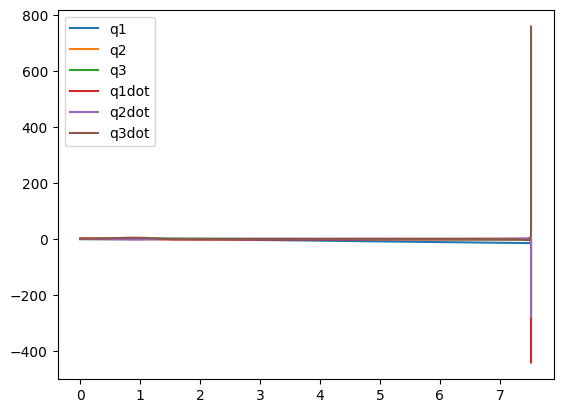

In [267]:
log_q = logger_q.FindLog(root_context)
log_F = logger_controller.FindLog(root_context)
log_theta = logger_theta.FindLog(root_context)

time_vect = log_q.sample_times()

plt.plot(time_vect, log_q.data()[0].transpose(), label='q1')
plt.plot(time_vect, log_q.data()[1].transpose(), label="q2")
plt.plot(time_vect, log_q.data()[2].transpose(), label='q3')
plt.plot(time_vect, log_q.data()[3].transpose(), label='q1dot')
plt.plot(time_vect, log_q.data()[4].transpose(), label='q2dot')
plt.plot(time_vect, log_q.data()[5].transpose(), label='q3dot')

plt.legend()


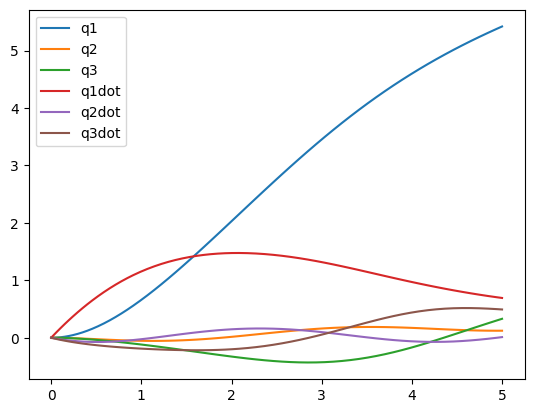

In [239]:
import matplotlib.pyplot as plt 



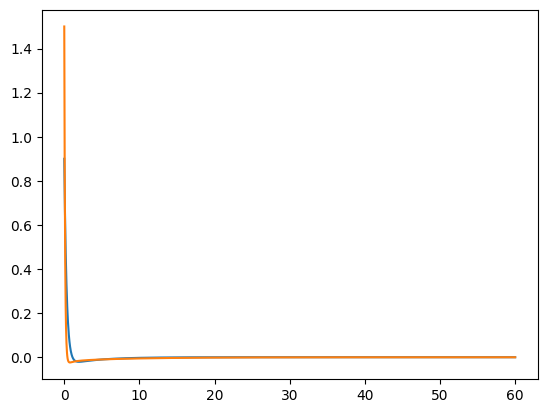

In [193]:

plt.plot(time_vect, log_F.data()[0].transpose())
plt.plot(time_vect, log_F.data()[1].transpose())


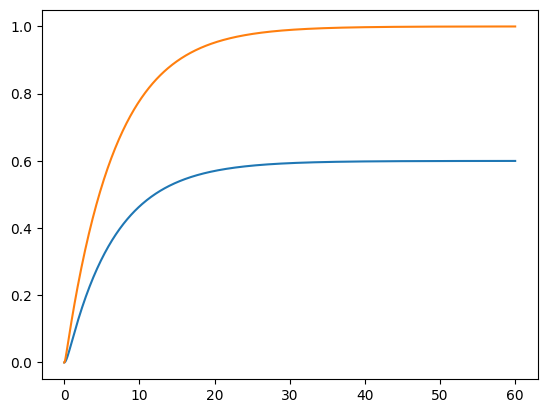

In [194]:

plt.plot(time_vect, log_theta.data()[0].transpose())
plt.plot(time_vect, log_theta.data()[1].transpose())


In [141]:
from pydot import graph_from_dot_data

def save_plant_svg_graph(diagram, destination_path):
    dot_format_graph = graph_from_dot_data(diagram.GetGraphvizString())[0]
    binary_data_svg = dot_format_graph.create_svg()
    with open(destination_path, 'wb') as f:
        f.write(binary_data_svg)

save_plant_svg_graph(BigDiagram, destination_path="../log/RR_planar.svg")